In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m26odel_mse import MultiDecoderCondVAE
from loss.l26oss_mse_1 import integrated_loss_fn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/train_loader.pt',weights_only= False)
val_loader = torch.load('torch/val_loader.pt',weights_only = False)
test_loader = torch.load('torch/test_loader.pt',weights_only=False)

In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]

In [6]:
model = MultiDecoderCondVAE(x_dim=x_dim,c_dim=c_dim,z_dim = 8 ).to(device)
early_stopping = EarlyStopping(patience = 40, min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay = 1e-5)

In [7]:
history = {'train_loss':[],'train_mse':[],'train_kl':[],'val_loss':[],'val_mse':[],'val_kl':[]}
epochs = 400

### train_val 시작 (beta = 1.0, gamma = 1.0)

In [8]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss, t_mse, t_kl = 0,0,0
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        x_hat, mu,logvar = model(x,c)
        loss_dict= integrated_loss_fn(x_hat,x,mu,logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t_mse += loss_dict['mse_loss'].item()
        t_kl += loss_dict['kl_loss'].item()

    model.eval()
    v_loss,v_mse,v_kl = 0,0,0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_x_hat, v_mu, v_logvar = model(v_x,v_c)
            v_loss_dict = integrated_loss_fn(v_x_hat,v_x, v_mu, v_logvar)
            v_loss += v_loss_dict['loss'].item()
            v_mse += v_loss_dict['mse_loss'].item()
            v_kl += v_loss_dict['kl_loss'].item()

    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_mse'].append(t_mse/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_mse'].append(v_mse/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))
    
    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break

   


Epoch [2/400]|Train:0.1100 |Val:0.1134
Epoch [20/400]|Train:0.0769 |Val:0.0865
Epoch [40/400]|Train:0.0671 |Val:0.0776
EarlyStopping counter: 1 out of 40
Epoch [60/400]|Train:0.0630 |Val:0.0733
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [80/400]|Train:0.0605 |Val:0.0709
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [100/400]|Train:0.0586 |Val:0.0688
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 

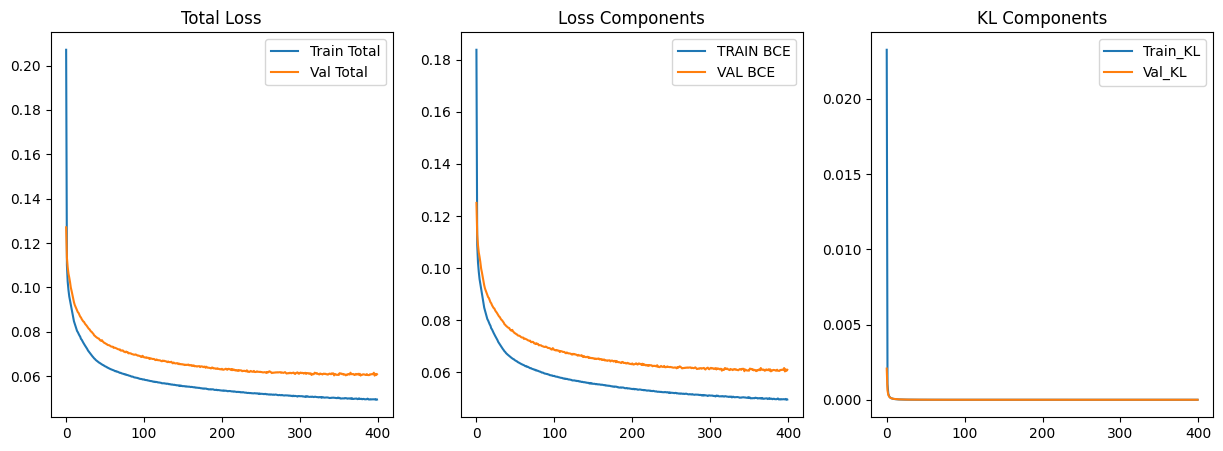

In [9]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_mse'], label='TRAIN BCE')
plt.plot(history['val_mse'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

### test 계산

In [10]:
import joblib
x_scaler = joblib.load('torch/abs_x_scaler.pkl')
# c_scaler = joblib.load('torch/sta_pre_re_scaler.pkl')

In [11]:
early_stopping.load_best_model(model)
model.eval()

all_x_true = []
all_x_pred = []
with torch.no_grad():
    for x_t,c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)
        x_hat,z_mu,z_logvar = model(x_t,c_t)
        all_x_true.append(x_t.cpu().numpy())
        all_x_pred.append(x_hat.cpu().numpy())
all_x_true = np.vstack(all_x_true)
all_x_pred = np.vstack(all_x_pred)
all_x_true = x_scaler.inverse_transform(all_x_true)
all_x_pred = x_scaler.inverse_transform(all_x_pred)

Restored best model with loss: 0.060289


In [12]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = all_x_true.flatten()
x_pred = all_x_pred.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
history = {'RMSE':round(float(rmse),4),'R2':round(float(r2),4)}

In [13]:
import json

In [14]:
# 파일 저장
save_path = "re_mse_metrics.json"

with open(save_path, 'w') as f:
    # float 타입 데이터도 json.dump를 통해 안전하게 저장됩니다.
    json.dump(history, f, indent=4)

print(f"숫자 형태로 {save_path}에 저장 완료!")

숫자 형태로 re_mse_metrics.json에 저장 완료!


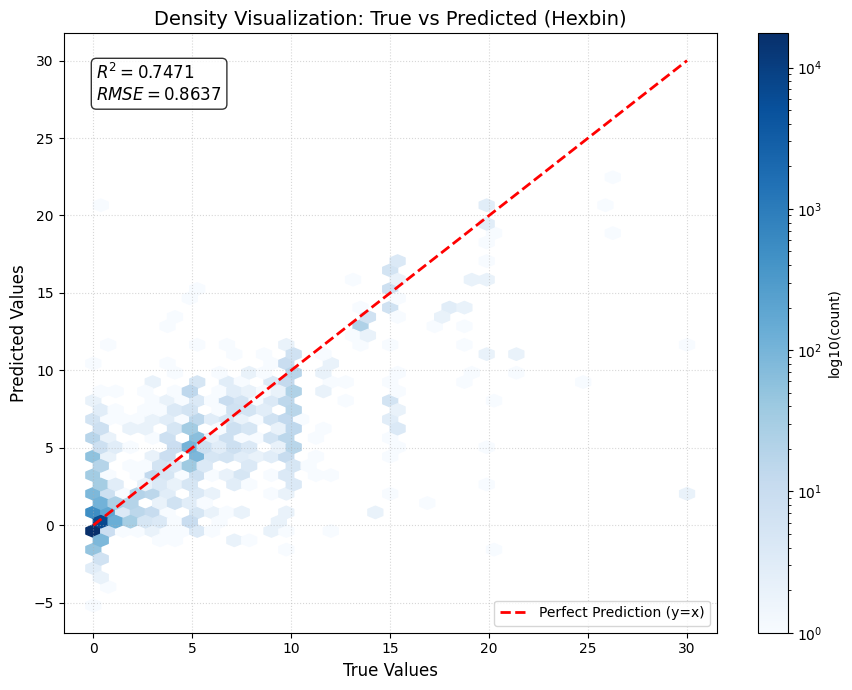

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(x_true, x_pred))
r2 = r2_score(x_true, x_pred)

plt.figure(figsize=(9, 7))

# ---------------------------------------------------------
# 수정 포인트: Hexbin Plot 사용
# gridsize: 육각형의 크기 (높을수록 세밀함)
# bins='log': 밀집도가 너무 차이날 때 로그 스케일로 색상 표현 (권장)
# ---------------------------------------------------------
hb = plt.hexbin(x_true, x_pred, gridsize=40, cmap='Blues', bins='log', mincnt=1)
cb = plt.colorbar(hb, label='log10(count)')

# y=x 대각선
max_val = max(x_true.max(), x_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

# 지표 표시
textstr = f'$R^2 = {r2:.4f}$\n$RMSE = {rmse:.4f}$'
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Density Visualization: True vs Predicted (Hexbin)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

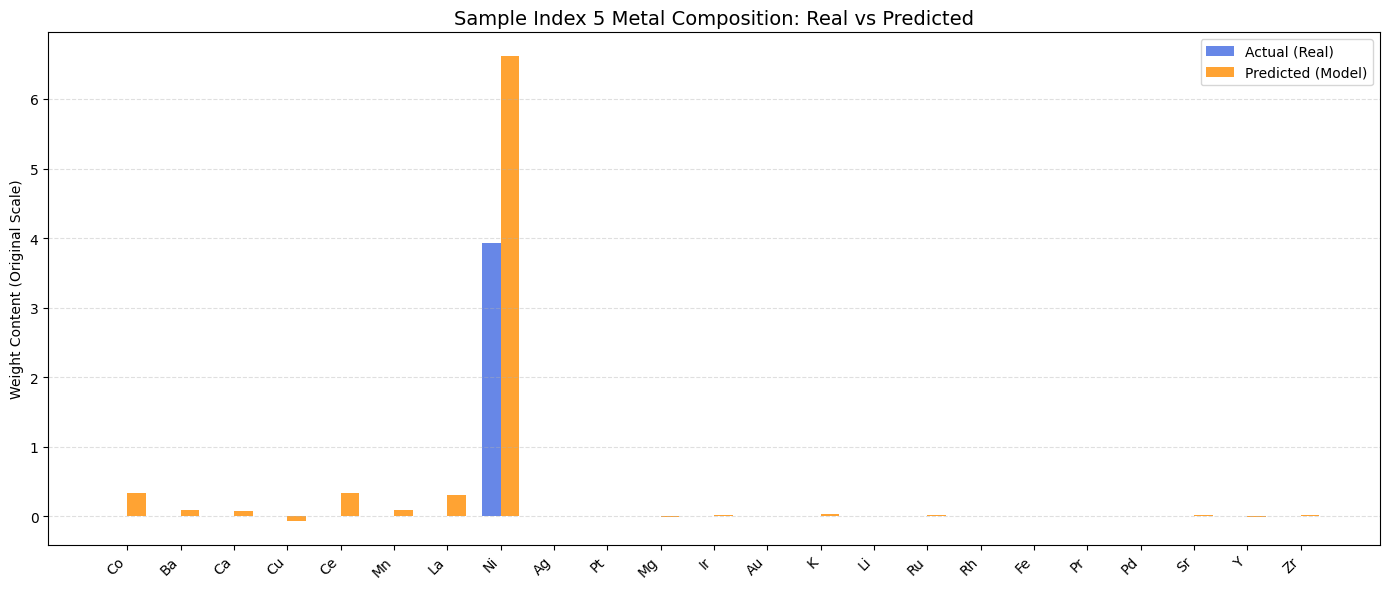

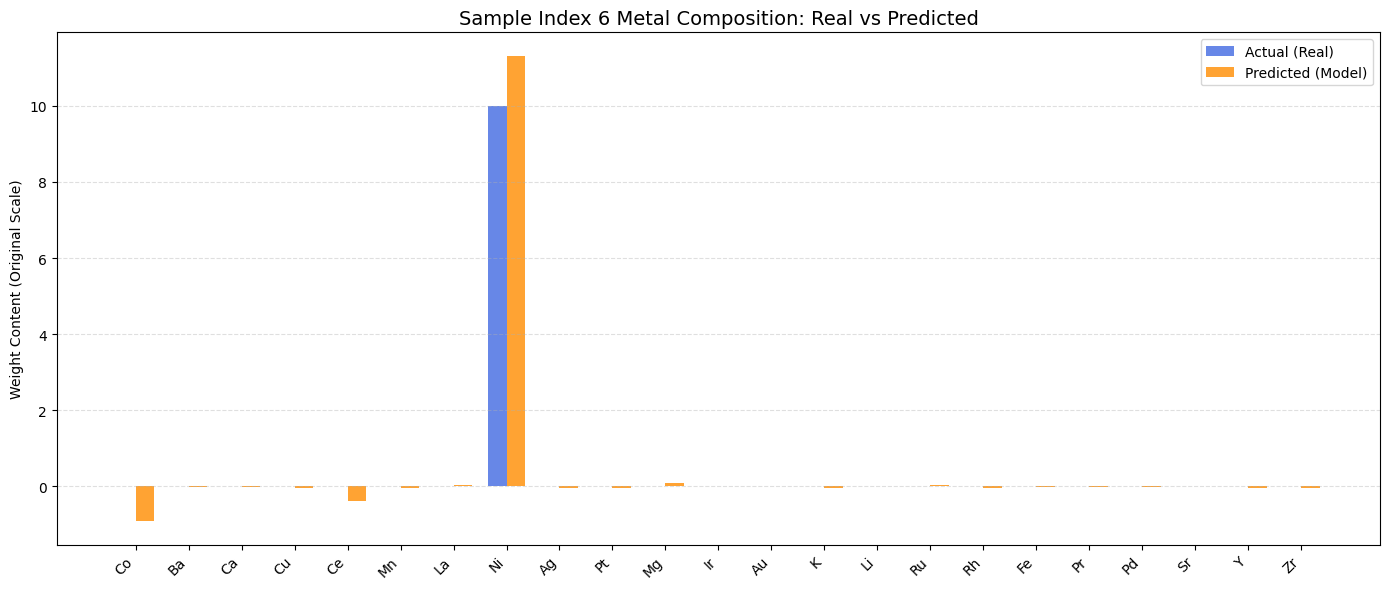

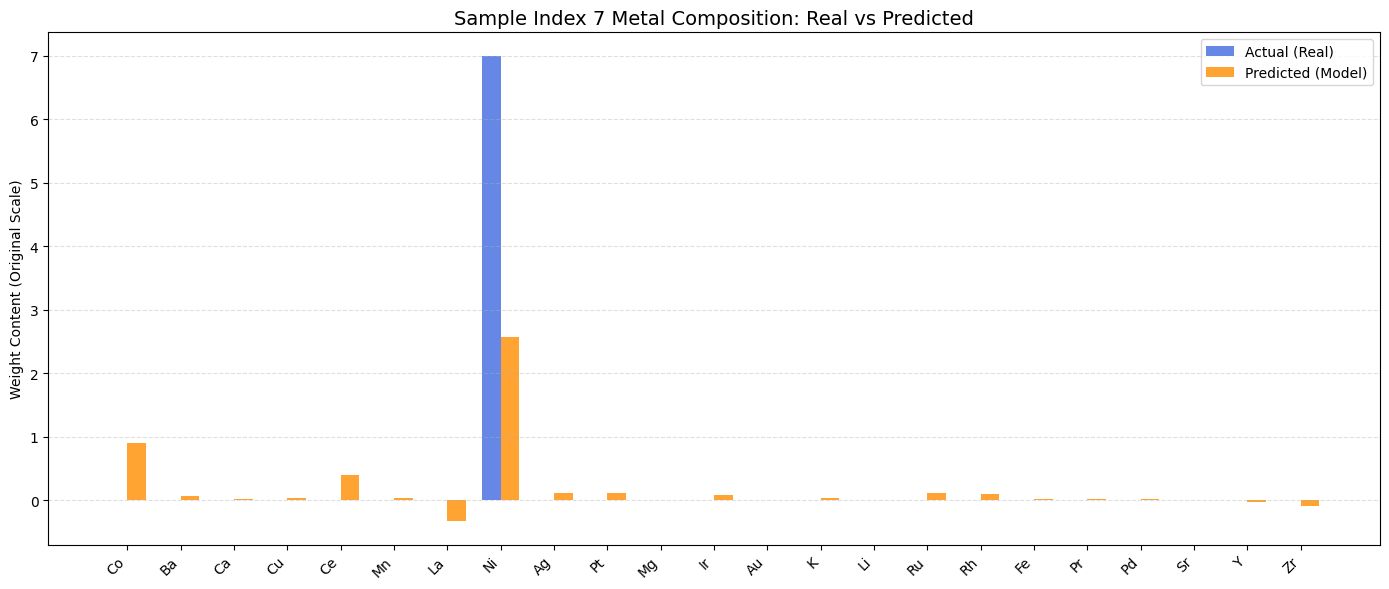

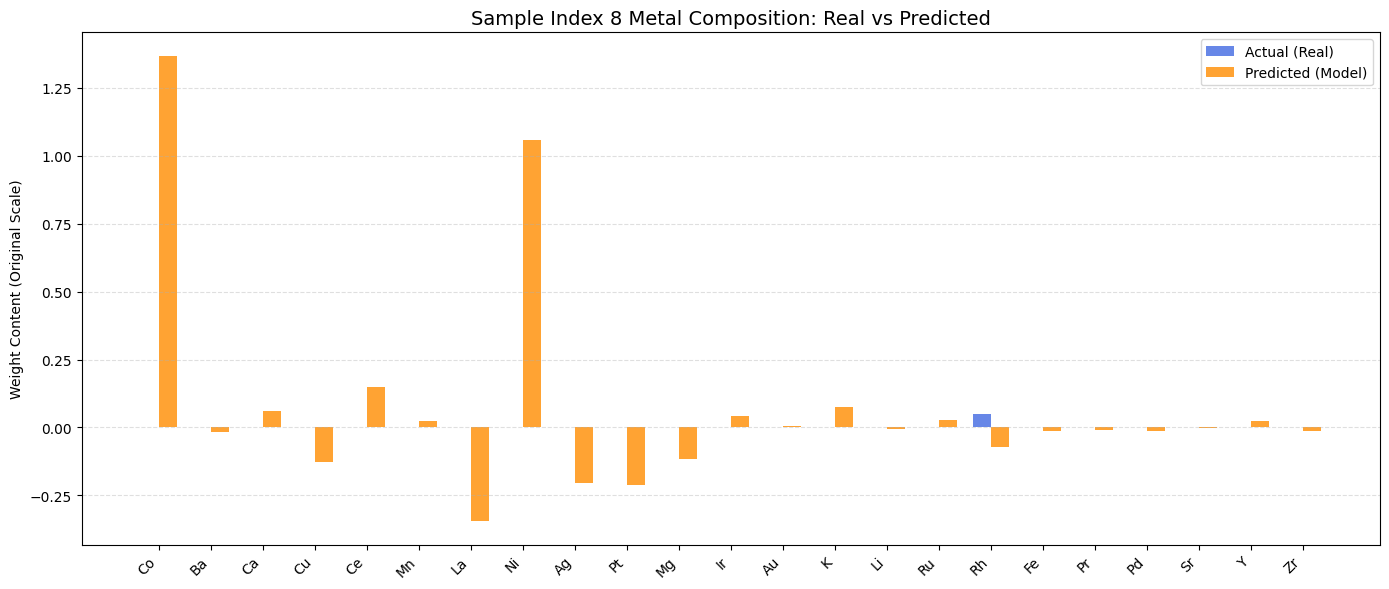

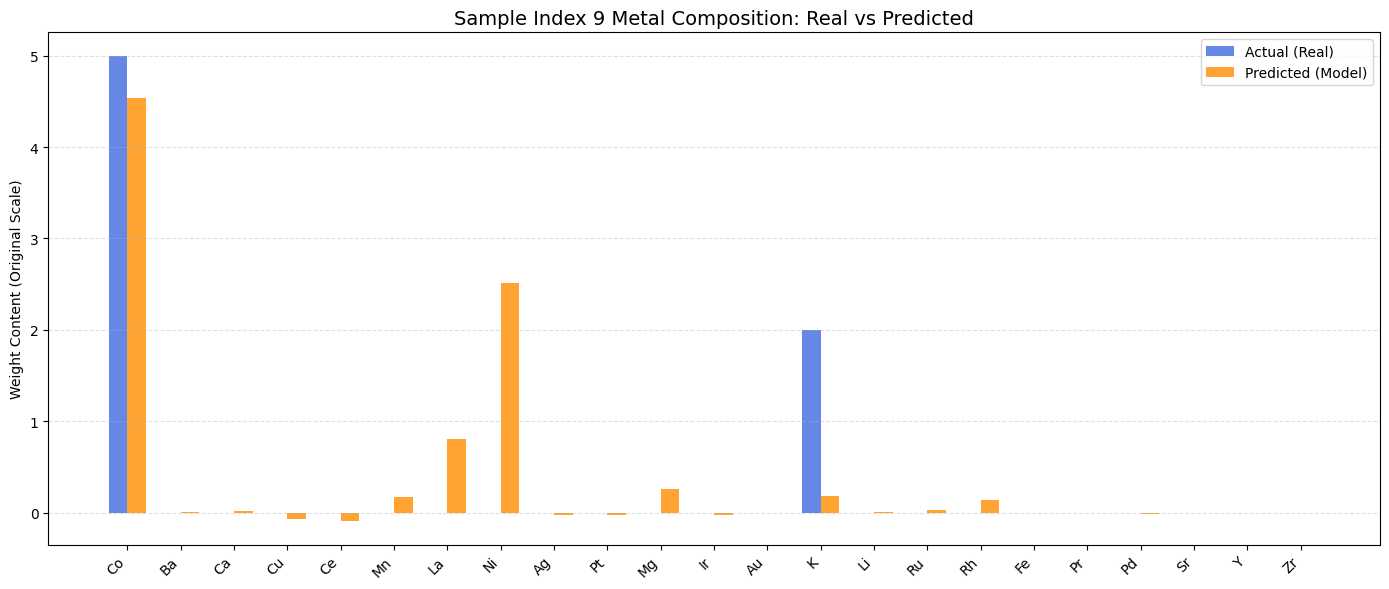

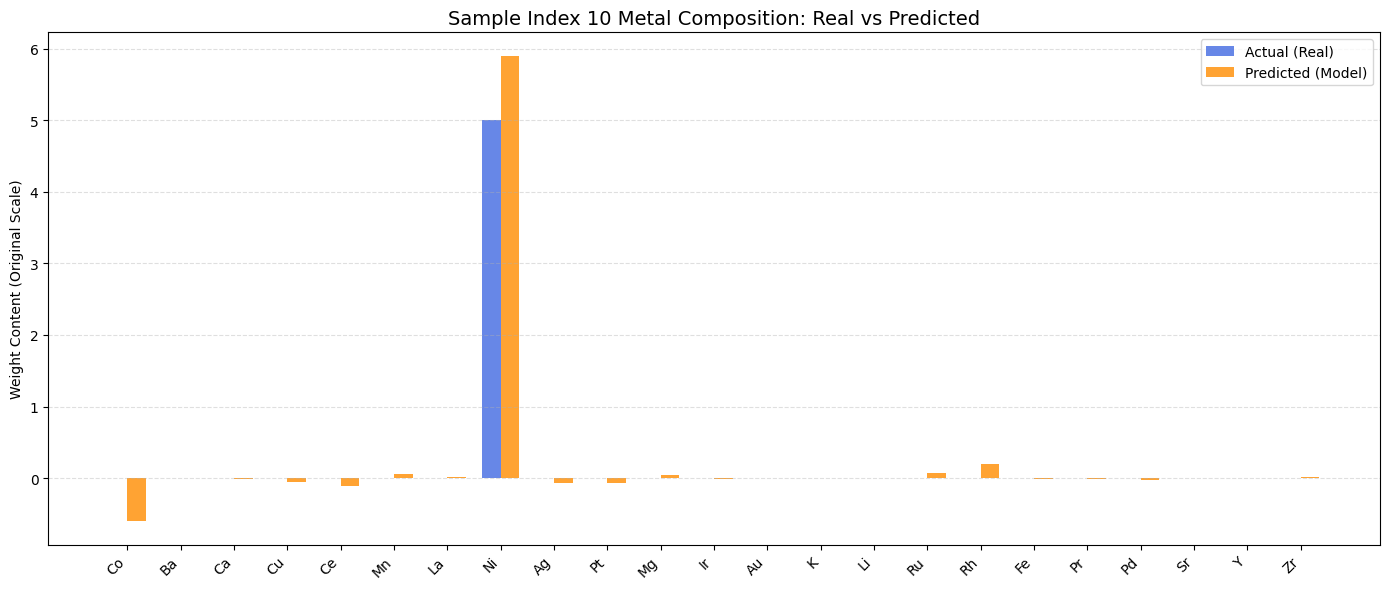

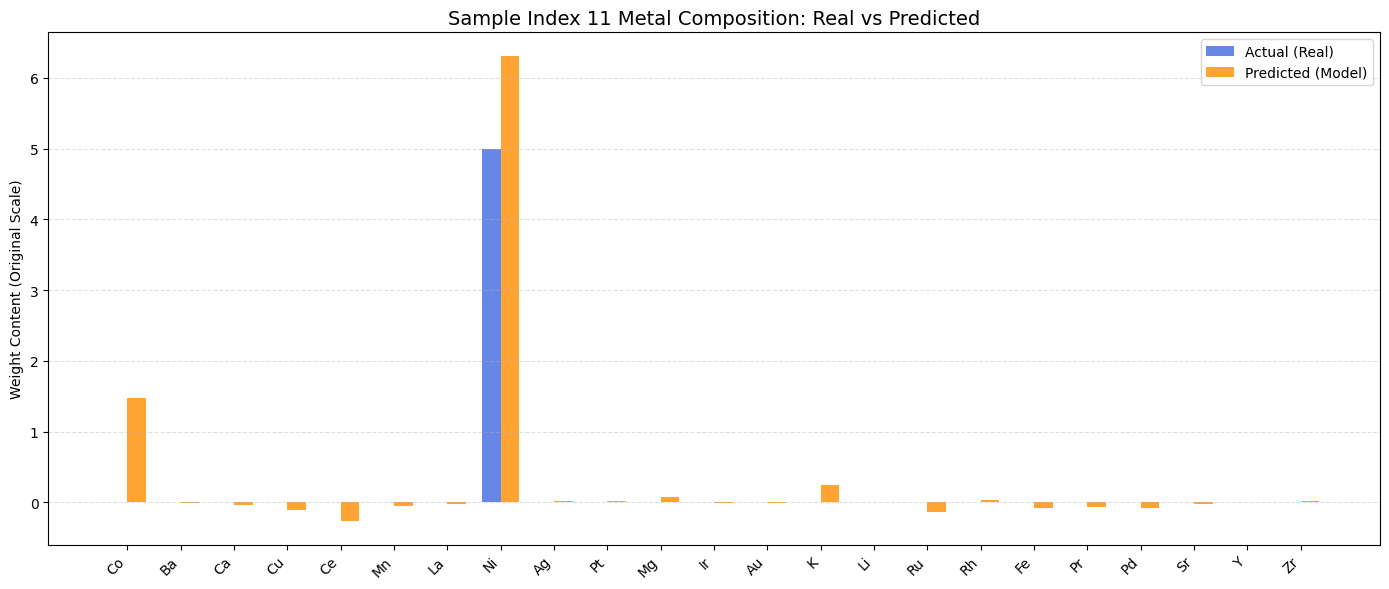

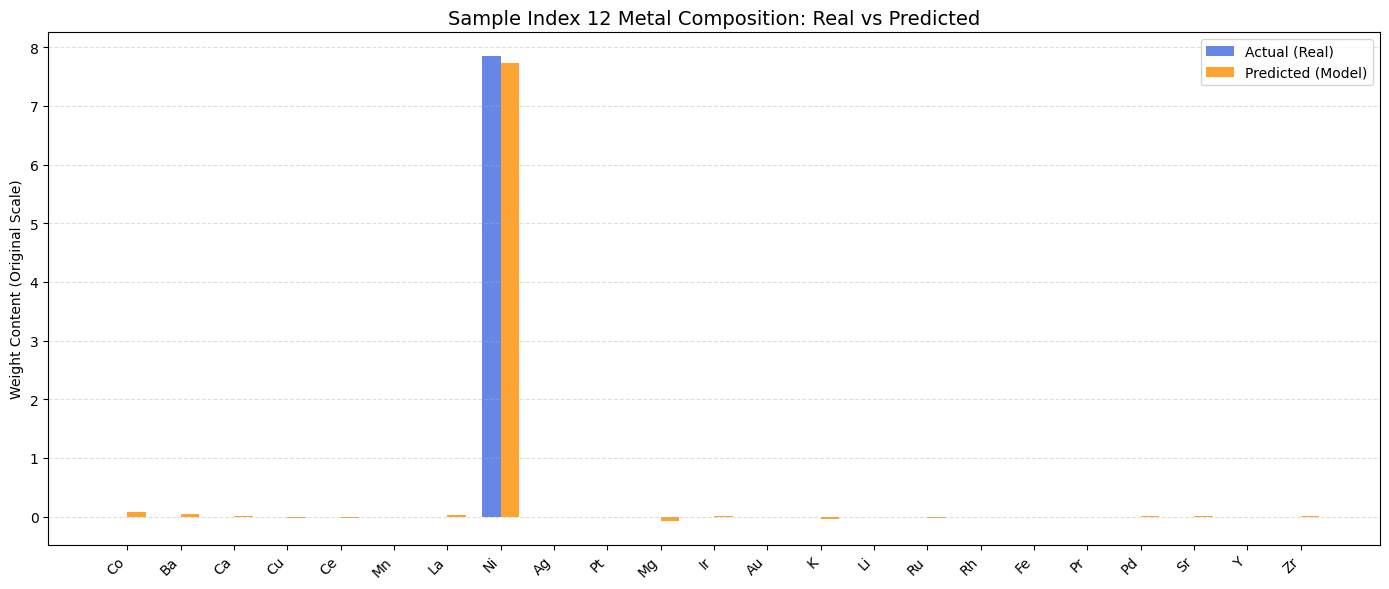

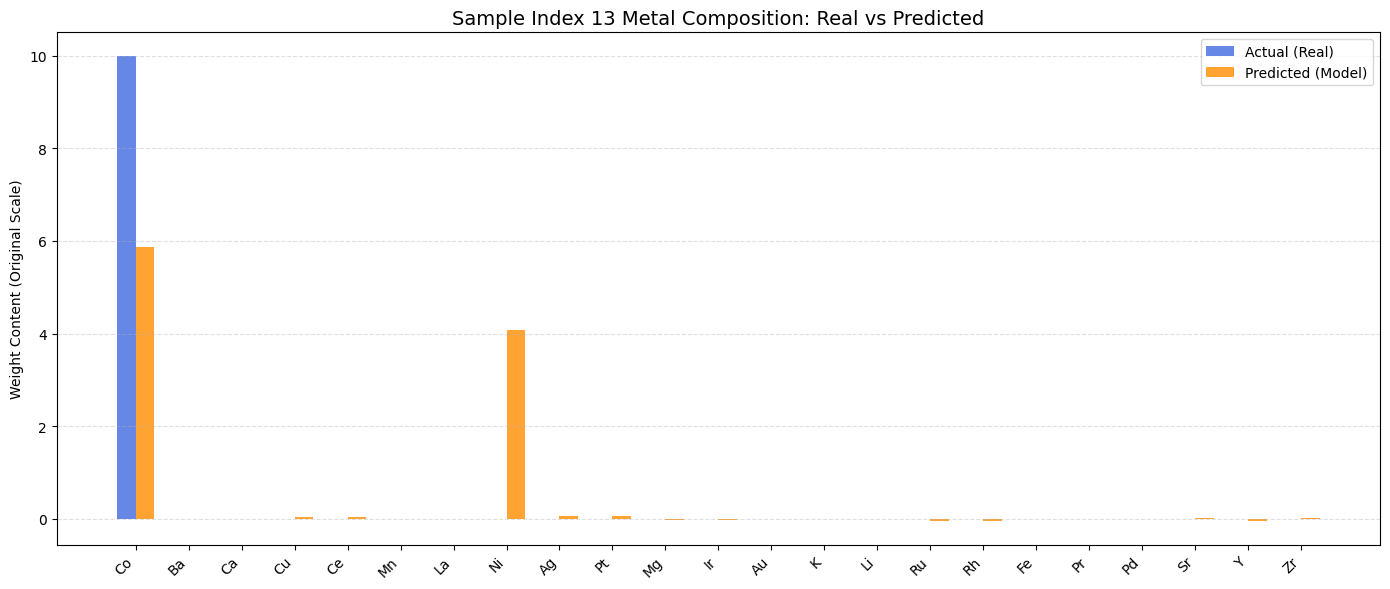

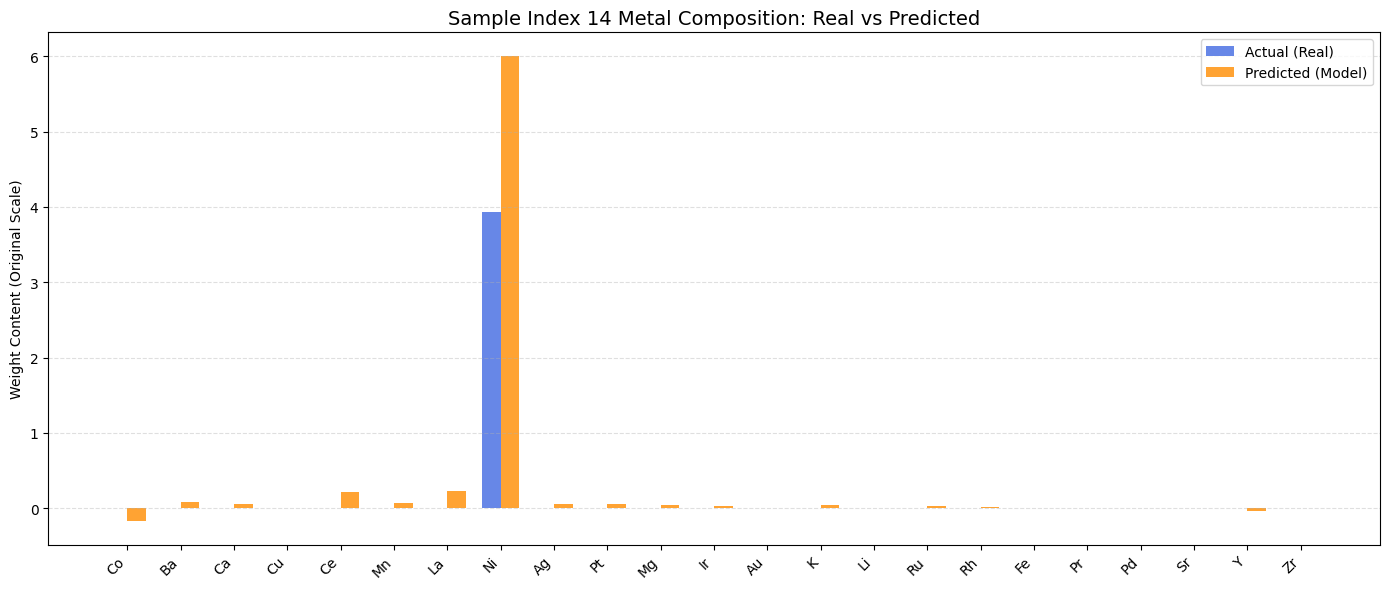

In [16]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2, all_x_true[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, all_x_pred[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()